In [1]:
TASK = "pose_multi"  # "pose_single", "pose_multi", "depth"
MODEL = "vgg19_bn"  # enter model name
N_EPOCHS = 128  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    16  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-4  # enter learning rate
AUGMENTATION = True
CONTINUE_TRAINING = False
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
num_outputs = 1
mode = None
multi_label = False

if TASK == "pose_single":
    mode = "pose"
    multi_label = False
elif TASK == "pose_multi":
    mode = "pose"
    multi_label = True
elif TASK == "depth":
    mode = "depth"
else:
    raise ValueError(f"Task {TASK} not supported yet.")

dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset",
    mode=mode,
    multi_label=multi_label,
    transform=None,
)

if TASK == "pose_multi":
    num_classes_p = len(dataset.idx_to_label_p)
    num_classes_r = len(dataset.idx_to_label_r)
    num_outputs = num_classes_p + num_classes_r
    print(f"Pose Multi: P classes={num_classes_p}, R classes={num_classes_r}")
elif TASK == "pose_single":
    num_outputs = len(dataset.idx_to_label)

print(f"mode: {mode}, num_outputs: {num_outputs}")
print(f"Total samples: {len(dataset)}")

Pose Multi: P classes=18, R classes=7
mode: pose, num_outputs: 25
Total samples: 2002


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    if TASK in ["pose_single", "pose_multi"]:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == "depth":
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15.0),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_outputs=num_outputs, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
if TASK in ["pose_single", "pose_multi"]:
    criterion = nn.CrossEntropyLoss()
elif TASK == "depth":
    criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
if AUGMENTATION:
    suffix = "_augmented"
else:
    suffix = ""

MODEL_NAME = f"{MODEL}_{TASK}{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # Stores Accuracy for pose, RMSE for depth
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        if TASK == "depth":
            labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)

        if TASK == "pose_multi":
            # labels: [batch, 2] (p, r)
            label_p = labels[:, 0]
            label_r = labels[:, 1]

            # Split output
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]

            loss = criterion(out_p, label_p) + criterion(out_r, label_r)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if TASK == "pose_single":
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        elif TASK == "pose_multi":
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]
            _, pred_p = torch.max(out_p, 1)
            _, pred_r = torch.max(out_r, 1)
            total += labels.size(0)
            # Joint accuracy: both must be correct
            correct += (
                ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
            )

    epoch_loss = running_loss / len(train_loader.dataset)

    if TASK in ["pose_single", "pose_multi"]:
        epoch_metric = correct / total
    else:
        epoch_metric = epoch_loss**0.5  # RMSE

    train_losses.append(epoch_loss)
    train_accs.append(epoch_metric)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            if TASK == "depth":
                labels = labels.float().unsqueeze(1)

            outputs = model(images)

            if TASK == "pose_multi":
                label_p = labels[:, 0]
                label_r = labels[:, 1]
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p:]
                loss = criterion(out_p, label_p) + criterion(out_r, label_r)
            else:
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            if TASK == "pose_single":
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
            elif TASK == "pose_multi":
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p:]
                _, pred_p = torch.max(out_p, 1)
                _, pred_r = torch.max(out_r, 1)
                val_total += labels.size(0)
                val_correct += (
                    ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
                )

    val_loss = val_running_loss / len(val_loader.dataset)

    if TASK in ["pose_single", "pose_multi"]:
        val_metric = val_correct / val_total
    else:
        val_metric = val_loss**0.5  # RMSE

    val_losses.append(val_loss)
    val_accs.append(val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metric": val_metric,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    metric_name = "Acc" if TASK in ["pose_single", "pose_multi"] else "RMSE"
    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} {metric_name}: {epoch_metric:.4f} | Val Loss: {val_loss:.4f} {metric_name}: {val_metric:.4f}"
    )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 3.8857)
Epoch 1/128 - Train Loss: 4.3596 Acc: 0.0569 | Val Loss: 3.8857 Acc: 0.0500


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 3.2859)
Epoch 2/128 - Train Loss: 3.5310 Acc: 0.0888 | Val Loss: 3.2859 Acc: 0.1250


100%|██████████| 46/46 [00:40<00:00,  1.12it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 2.2726)
Epoch 3/128 - Train Loss: 3.0042 Acc: 0.1477 | Val Loss: 2.2726 Acc: 0.2750


100%|██████████| 46/46 [00:40<00:00,  1.12it/s]


Epoch 4/128 - Train Loss: 2.4699 Acc: 0.2136 | Val Loss: 2.5637 Acc: 0.1938


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.8910)
Epoch 5/128 - Train Loss: 2.1285 Acc: 0.2732 | Val Loss: 1.8910 Acc: 0.3312


100%|██████████| 46/46 [00:40<00:00,  1.12it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.7142)
Epoch 6/128 - Train Loss: 1.9298 Acc: 0.3287 | Val Loss: 1.7142 Acc: 0.4062


100%|██████████| 46/46 [00:40<00:00,  1.12it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.6001)
Epoch 7/128 - Train Loss: 1.8088 Acc: 0.3578 | Val Loss: 1.6001 Acc: 0.4125


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


Epoch 8/128 - Train Loss: 1.4479 Acc: 0.4667 | Val Loss: 2.7638 Acc: 0.1812


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.4671)
Epoch 9/128 - Train Loss: 1.4496 Acc: 0.4861 | Val Loss: 1.4671 Acc: 0.5062


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.0756)
Epoch 10/128 - Train Loss: 1.3253 Acc: 0.5021 | Val Loss: 1.0756 Acc: 0.5188


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 1.0069)
Epoch 11/128 - Train Loss: 1.0906 Acc: 0.5839 | Val Loss: 1.0069 Acc: 0.5687


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Epoch 12/128 - Train Loss: 1.0420 Acc: 0.5971 | Val Loss: 1.2036 Acc: 0.5437


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.9719)
Epoch 13/128 - Train Loss: 0.9637 Acc: 0.6234 | Val Loss: 0.9719 Acc: 0.6562


100%|██████████| 46/46 [00:40<00:00,  1.12it/s]


Epoch 14/128 - Train Loss: 0.8493 Acc: 0.6803 | Val Loss: 0.9823 Acc: 0.6188


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.7156)
Epoch 15/128 - Train Loss: 0.7859 Acc: 0.7094 | Val Loss: 0.7156 Acc: 0.6750


100%|██████████| 46/46 [00:40<00:00,  1.13it/s]


Epoch 16/128 - Train Loss: 0.7350 Acc: 0.7143 | Val Loss: 1.0344 Acc: 0.6375


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 17/128 - Train Loss: 0.7136 Acc: 0.7517 | Val Loss: 0.8850 Acc: 0.6375


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 18/128 - Train Loss: 0.6131 Acc: 0.7871 | Val Loss: 1.1134 Acc: 0.6500


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 19/128 - Train Loss: 0.7112 Acc: 0.7393 | Val Loss: 1.0988 Acc: 0.6312


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 20/128 - Train Loss: 0.7041 Acc: 0.7406 | Val Loss: 3.6057 Acc: 0.3688


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 21/128 - Train Loss: 1.0383 Acc: 0.6352 | Val Loss: 0.7394 Acc: 0.7000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 22/128 - Train Loss: 0.7597 Acc: 0.7219 | Val Loss: 1.1279 Acc: 0.6000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.5102)
Epoch 23/128 - Train Loss: 0.5383 Acc: 0.7982 | Val Loss: 0.5102 Acc: 0.8063


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 24/128 - Train Loss: 0.6019 Acc: 0.7822 | Val Loss: 0.8237 Acc: 0.6625


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 25/128 - Train Loss: 0.4520 Acc: 0.8294 | Val Loss: 0.5267 Acc: 0.8187


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.4713)
Epoch 26/128 - Train Loss: 0.3293 Acc: 0.8710 | Val Loss: 0.4713 Acc: 0.8438


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.2783)
Epoch 27/128 - Train Loss: 0.2611 Acc: 0.9015 | Val Loss: 0.2783 Acc: 0.9000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 28/128 - Train Loss: 0.2637 Acc: 0.8981 | Val Loss: 0.4868 Acc: 0.8187


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.2370)
Epoch 29/128 - Train Loss: 0.2432 Acc: 0.9105 | Val Loss: 0.2370 Acc: 0.9000


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 30/128 - Train Loss: 0.2160 Acc: 0.9286 | Val Loss: 0.2463 Acc: 0.9187


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 31/128 - Train Loss: 0.1759 Acc: 0.9404 | Val Loss: 0.2758 Acc: 0.9125


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 32/128 - Train Loss: 0.5219 Acc: 0.8280 | Val Loss: 0.9893 Acc: 0.6813


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 33/128 - Train Loss: 0.5376 Acc: 0.8183 | Val Loss: 0.2645 Acc: 0.8938


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 34/128 - Train Loss: 0.3108 Acc: 0.8904 | Val Loss: 0.3238 Acc: 0.8875


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 35/128 - Train Loss: 0.1940 Acc: 0.9362 | Val Loss: 0.3632 Acc: 0.8875


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.1568)
Epoch 36/128 - Train Loss: 0.1831 Acc: 0.9307 | Val Loss: 0.1568 Acc: 0.9563


100%|██████████| 46/46 [00:40<00:00,  1.14it/s]


Epoch 37/128 - Train Loss: 0.1746 Acc: 0.9390 | Val Loss: 0.5348 Acc: 0.8500


100%|██████████| 46/46 [00:42<00:00,  1.09it/s]


Epoch 38/128 - Train Loss: 0.5965 Acc: 0.8232 | Val Loss: 0.5700 Acc: 0.8063


100%|██████████| 46/46 [01:10<00:00,  1.52s/it]


Epoch 39/128 - Train Loss: 0.4234 Acc: 0.8578 | Val Loss: 0.3613 Acc: 0.8750


100%|██████████| 46/46 [01:18<00:00,  1.70s/it]


Epoch 40/128 - Train Loss: 0.1824 Acc: 0.9341 | Val Loss: 0.3030 Acc: 0.9000


100%|██████████| 46/46 [01:20<00:00,  1.74s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.1199)
Epoch 41/128 - Train Loss: 0.1904 Acc: 0.9383 | Val Loss: 0.1199 Acc: 0.9563


100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Epoch 42/128 - Train Loss: 0.1702 Acc: 0.9376 | Val Loss: 0.3495 Acc: 0.8812


100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.1079)
Epoch 43/128 - Train Loss: 0.1555 Acc: 0.9556 | Val Loss: 0.1079 Acc: 0.9625


100%|██████████| 46/46 [01:28<00:00,  1.93s/it]


Epoch 44/128 - Train Loss: 0.1246 Acc: 0.9549 | Val Loss: 0.7150 Acc: 0.7562


100%|██████████| 46/46 [01:32<00:00,  2.01s/it]


Epoch 45/128 - Train Loss: 0.1379 Acc: 0.9459 | Val Loss: 0.3114 Acc: 0.9000


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


Epoch 46/128 - Train Loss: 0.1230 Acc: 0.9549 | Val Loss: 0.3357 Acc: 0.9062


100%|██████████| 46/46 [01:33<00:00,  2.04s/it]


Epoch 47/128 - Train Loss: 0.2831 Acc: 0.9078 | Val Loss: 0.1811 Acc: 0.9187


100%|██████████| 46/46 [01:35<00:00,  2.07s/it]


Epoch 48/128 - Train Loss: 0.1462 Acc: 0.9501 | Val Loss: 0.3390 Acc: 0.9000


100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Epoch 49/128 - Train Loss: 0.9169 Acc: 0.7323 | Val Loss: 0.2662 Acc: 0.9375


100%|██████████| 46/46 [01:33<00:00,  2.04s/it]


Epoch 50/128 - Train Loss: 0.3101 Acc: 0.8849 | Val Loss: 0.2580 Acc: 0.9125


100%|██████████| 46/46 [01:33<00:00,  2.03s/it]


Epoch 51/128 - Train Loss: 0.2068 Acc: 0.9293 | Val Loss: 0.1889 Acc: 0.9000


100%|██████████| 46/46 [01:34<00:00,  2.04s/it]


Epoch 52/128 - Train Loss: 0.1150 Acc: 0.9598 | Val Loss: 0.1499 Acc: 0.9313


100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Epoch 53/128 - Train Loss: 0.1136 Acc: 0.9577 | Val Loss: 0.1288 Acc: 0.9563


100%|██████████| 46/46 [05:16<00:00,  6.87s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.0838)
Epoch 54/128 - Train Loss: 0.1153 Acc: 0.9626 | Val Loss: 0.0838 Acc: 0.9563


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]


Epoch 55/128 - Train Loss: 0.0652 Acc: 0.9806 | Val Loss: 0.2223 Acc: 0.9375


100%|██████████| 46/46 [01:01<00:00,  1.33s/it]


Epoch 56/128 - Train Loss: 0.1235 Acc: 0.9584 | Val Loss: 0.1629 Acc: 0.9500


100%|██████████| 46/46 [01:46<00:00,  2.31s/it]


Epoch 57/128 - Train Loss: 0.1345 Acc: 0.9549 | Val Loss: 0.1831 Acc: 0.9500


100%|██████████| 46/46 [01:53<00:00,  2.46s/it]


Epoch 58/128 - Train Loss: 0.1567 Acc: 0.9521 | Val Loss: 0.1780 Acc: 0.9313


100%|██████████| 46/46 [02:00<00:00,  2.62s/it]


Epoch 59/128 - Train Loss: 0.1852 Acc: 0.9355 | Val Loss: 0.4876 Acc: 0.8562


100%|██████████| 46/46 [02:08<00:00,  2.80s/it]


Epoch 60/128 - Train Loss: 0.1372 Acc: 0.9584 | Val Loss: 0.2648 Acc: 0.9062


100%|██████████| 46/46 [01:44<00:00,  2.28s/it]


Epoch 61/128 - Train Loss: 0.0567 Acc: 0.9820 | Val Loss: 0.2960 Acc: 0.9500


100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Epoch 62/128 - Train Loss: 0.3756 Acc: 0.8877 | Val Loss: 0.5274 Acc: 0.8562


100%|██████████| 46/46 [01:36<00:00,  2.09s/it]


Epoch 63/128 - Train Loss: 0.2346 Acc: 0.9182 | Val Loss: 0.5326 Acc: 0.8500


100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Epoch 64/128 - Train Loss: 0.3006 Acc: 0.9126 | Val Loss: 0.3682 Acc: 0.9125


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


Epoch 65/128 - Train Loss: 0.2598 Acc: 0.9126 | Val Loss: 0.2024 Acc: 0.9375


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.0568)
Epoch 66/128 - Train Loss: 0.0983 Acc: 0.9688 | Val Loss: 0.0568 Acc: 0.9750


100%|██████████| 46/46 [01:35<00:00,  2.08s/it]


Epoch 67/128 - Train Loss: 0.2348 Acc: 0.9196 | Val Loss: 0.2530 Acc: 0.9313


100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Epoch 68/128 - Train Loss: 0.1413 Acc: 0.9508 | Val Loss: 0.1547 Acc: 0.9437


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


Epoch 69/128 - Train Loss: 0.1466 Acc: 0.9480 | Val Loss: 0.1346 Acc: 0.9625


100%|██████████| 46/46 [01:29<00:00,  1.95s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.0449)
Epoch 70/128 - Train Loss: 0.3287 Acc: 0.9140 | Val Loss: 0.0449 Acc: 0.9938


100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Epoch 71/128 - Train Loss: 0.1118 Acc: 0.9556 | Val Loss: 0.1973 Acc: 0.9500


100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Epoch 72/128 - Train Loss: 0.1030 Acc: 0.9702 | Val Loss: 0.4612 Acc: 0.8812


100%|██████████| 46/46 [01:26<00:00,  1.87s/it]


Epoch 73/128 - Train Loss: 0.0644 Acc: 0.9764 | Val Loss: 0.2202 Acc: 0.9563


100%|██████████| 46/46 [01:23<00:00,  1.80s/it]


Epoch 74/128 - Train Loss: 0.0496 Acc: 0.9840 | Val Loss: 0.1178 Acc: 0.9750


100%|██████████| 46/46 [01:21<00:00,  1.76s/it]


Epoch 75/128 - Train Loss: 0.0765 Acc: 0.9764 | Val Loss: 0.1128 Acc: 0.9500


100%|██████████| 46/46 [01:17<00:00,  1.69s/it]


Epoch 76/128 - Train Loss: 0.0571 Acc: 0.9806 | Val Loss: 0.0869 Acc: 0.9750


100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


Saved best model to ../model/vgg19_bn_pose_multi_augmented.pth (Val Loss: 0.0384)
Epoch 77/128 - Train Loss: 0.0404 Acc: 0.9861 | Val Loss: 0.0384 Acc: 0.9750


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 78/128 - Train Loss: 0.0436 Acc: 0.9854 | Val Loss: 0.0713 Acc: 0.9812


100%|██████████| 46/46 [01:17<00:00,  1.67s/it]


Epoch 79/128 - Train Loss: 0.0435 Acc: 0.9834 | Val Loss: 0.0441 Acc: 0.9875


100%|██████████| 46/46 [01:17<00:00,  1.70s/it]


Epoch 80/128 - Train Loss: 0.0562 Acc: 0.9764 | Val Loss: 0.1848 Acc: 0.9187


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 81/128 - Train Loss: 0.0896 Acc: 0.9674 | Val Loss: 0.1283 Acc: 0.9750


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 82/128 - Train Loss: 0.0985 Acc: 0.9695 | Val Loss: 0.0720 Acc: 0.9750


100%|██████████| 46/46 [01:17<00:00,  1.67s/it]


Epoch 83/128 - Train Loss: 0.1049 Acc: 0.9695 | Val Loss: 0.2847 Acc: 0.9437


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 84/128 - Train Loss: 0.0430 Acc: 0.9847 | Val Loss: 0.1837 Acc: 0.9500


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 85/128 - Train Loss: 0.0367 Acc: 0.9861 | Val Loss: 0.0692 Acc: 0.9875


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 86/128 - Train Loss: 0.3927 Acc: 0.8960 | Val Loss: 0.8868 Acc: 0.7312


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 87/128 - Train Loss: 0.2836 Acc: 0.9168 | Val Loss: 0.1551 Acc: 0.9437


100%|██████████| 46/46 [01:17<00:00,  1.68s/it]


Epoch 88/128 - Train Loss: 0.3274 Acc: 0.8967 | Val Loss: 0.3063 Acc: 0.8938


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 89/128 - Train Loss: 0.1819 Acc: 0.9397 | Val Loss: 0.1910 Acc: 0.9437


100%|██████████| 46/46 [01:17<00:00,  1.68s/it]


Epoch 90/128 - Train Loss: 0.0784 Acc: 0.9750 | Val Loss: 0.1990 Acc: 0.9500


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 91/128 - Train Loss: 0.0642 Acc: 0.9778 | Val Loss: 0.1814 Acc: 0.9563


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


Epoch 92/128 - Train Loss: 0.0722 Acc: 0.9785 | Val Loss: 0.0917 Acc: 0.9688


100%|██████████| 46/46 [01:17<00:00,  1.68s/it]


Epoch 93/128 - Train Loss: 0.0540 Acc: 0.9868 | Val Loss: 0.1289 Acc: 0.9500
Early stopping triggered. No improvement for 16 epochs.


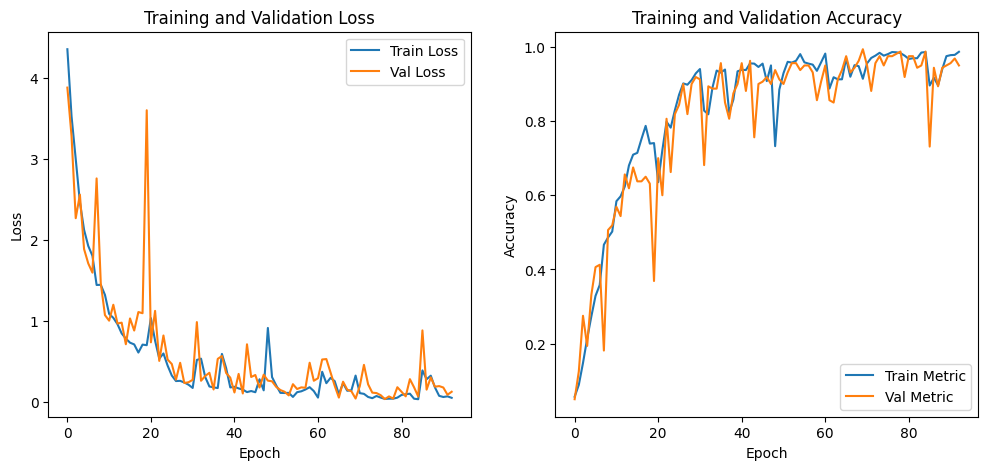

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Metric")
plt.plot(val_accs, label="Val Metric")
plt.xlabel("Epoch")
plt.ylabel("Accuracy" if TASK in ["pose_single", "pose_multi"] else "RMSE")
plt.legend()
plt.title(
    f"Training and Validation {'Accuracy' if TASK in ['pose_single', 'pose_multi'] else 'RMSE'}"
)

plt.show()

In [9]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_metric_loaded = checkpoint.get("val_metric")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_metric={val_metric_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0
test_mse_sum = 0
test_correct_p = 0
test_correct_r = 0

criterion_test = nn.MSELoss(reduction="sum")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        if TASK == "depth":
            labels = labels.float().unsqueeze(1)

        outputs = model(images)

        if TASK == "pose_single":
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        elif TASK == "pose_multi":
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]
            _, pred_p = torch.max(out_p, 1)
            _, pred_r = torch.max(out_r, 1)
            test_total += labels.size(0)

            # Individual accuracies
            test_correct_p += (pred_p == labels[:, 0]).sum().item()
            test_correct_r += (pred_r == labels[:, 1]).sum().item()

            # Joint accuracy
            test_correct += (
                ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
            )
        else:
            loss = criterion_test(outputs, labels)
            test_mse_sum += loss.item()
            test_total += labels.size(0)

if TASK in ["pose_single", "pose_multi"]:
    test_metric = test_correct / test_total
    print(f"Test Set Accuracy: {test_metric:.4f}")
    if TASK == "pose_multi":
        accuracy_p = test_correct_p / test_total
        accuracy_r = test_correct_r / test_total
        print(f"Test Set P Accuracy: {accuracy_p:.4f}")
        print(f"Test Set R Accuracy: {accuracy_r:.4f}")
else:
    test_metric = (test_mse_sum / test_total) ** 0.5
    print(f"Test Set RMSE: {test_metric:.4f}")

Loaded checkpoint from ../model/vgg19_bn_pose_multi_augmented.pth (epoch=77, val_metric=0.975, val_loss=0.03840460628271103)
Test Set Accuracy: 0.9900
Test Set P Accuracy: 0.9900
Test Set R Accuracy: 1.0000


In [10]:
results = {
    "model_name": MODEL_NAME,
    "metric_name": "accuracy" if TASK in ["pose_single", "pose_multi"] else "rmse",
    "metric_value": test_metric,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
    },
}

if TASK == "pose_multi":
    results["metadata"]["accuracy_p"] = accuracy_p
    results["metadata"]["accuracy_r"] = accuracy_r

out_dir = f"../eval/{TASK}"
out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to ../eval/pose_multi/vgg19_bn_pose_multi_augmented.json
